In [1]:
import numpy as np

from tqdm import tqdm  # Import tqdm for progress tracking
from numpy.linalg import inv, slogdet
import matplotlib.pyplot as plt


X = np.load("D:\Downloads\mnist.npz")
X_train = X["x_train"]
X_test = X["x_test"]
y_train = X["y_train"]
y_test = X["y_test"]

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Choose 100 samples from each class
# samples_per_class = 100
# selected_samples = []
# y_trains = []
# for i in range(10):
#     class_indices = np.where(y_train == i)[0][:samples_per_class]
#     selected_samples.extend(class_indices)
#     y_trains.extend([i]*samples_per_class)

# y_trains = np.array(y_trains)
# # Create data matrix X
# X = X_train[selected_samples].reshape(-1,784)
# X = X.T

# # # Remove mean from X
# X_centered = X - np.mean(X, axis=1, keepdims=True)

# # Apply PCA on centralized X
# covariance_matrix = np.matmul(X_centered, X_centered.T) / ((samples_per_class * 10) - 1)
# _, U = np.linalg.eigh(covariance_matrix)

# # Sort eigenvectors in descending order
# sorted_indices = np.argsort(-np.diag(U))
# U_sorted = U[:, sorted_indices]

# # Perform Y = U^T * X
# Y = U_sorted.T @ X_centered

# # Reconstruct X
# X_recon = U_sorted @ Y #+ np.mean(X, axis=1, keepdims=True)

# # Manually implement Mean Squared Error (MSE)
# mse = np.sum((X_centered - X_recon)**2) / X_centered.size
# print("MSE between X and X_recon:", mse)

# # Choose p = 5, 10, 20 eigenvectors from U_sorted
# p_values = [5, 10, 20,300,784]
# for p in p_values:
#     Up = U_sorted[:, :p]
#     # print(Up.shape,X_centered.shape)
#     Yp = Up.T @ X_centered
#     X_recon_p = Up@ Yp

#     # Reshape each column to 28x28 and plot images
#     # print(X_recon_p.shape)
#     fig, axes = plt.subplots(10, 5, figsize=(10, 10))
#     for i in range(10):
#         for j in range(5):
#             axes[i, j].imshow(X_recon_p[:, i * 100 + j].reshape(28, 28), cmap='cubehelix_r')
#             axes[i, j].axis('off')

#     plt.suptitle(f"Reconstructed Images with p={p}")
#     plt.show()




In [3]:


# Function to compute QDA on GPU
def qda_gpu(x, prior, mean, covariance):
    noise_level = 1e-6
    covariance += noise_level * np.eye(covariance.shape[0])

    inv_covariance = np.linalg.inv(covariance)
    log_cov = np.linalg.slogdet(covariance)[1]

    x_flatten = x.reshape(x.shape[0], -1)

    # Calculate the quadratic form part of the QDA expression
    quadratic_form = np.sum((x_flatten @ inv_covariance) * x_flatten, axis=1)

    # Calculate the linear part of the QDA expression
    linear_part = np.sum(mean * (inv_covariance @ x_flatten.T).T, axis=1) * (-2)

    # Calculate the constant part of the QDA expression
    constant_part = mean @ inv_covariance @ mean

    # Combine all parts to get the final QDA expression
    qda_result = -0.5 * (quadratic_form + linear_part + constant_part + log_cov) + np.log(prior)

    return qda_result

# Function to compute QDA parameters
def compute_qda_params(X_train, y_train):
    # Compute prior probabilities for each class
    prior_probabilities = [np.mean(y_train == i) for i in range(10)]

    # Compute mean and covariance vectors for each class
    mean_vectors = []
    covariance_matrices = []

    for i in tqdm(range(10), desc="Computing QDA Params"):  # Use tqdm for progress tracking
        class_samples = X_train.T[y_train == i]
        mean_vector = np.mean(class_samples, axis=0).flatten()
        covariance_matrix = np.cov(class_samples.reshape(class_samples.shape[0], -1), rowvar=False)

        mean_vectors.append(mean_vector)
        covariance_matrices.append(covariance_matrix)

    # Convert the lists to NumPy arrays
    mean_vectors = np.array(mean_vectors)
    covariance_matrices = np.array(covariance_matrices)

    return prior_probabilities, mean_vectors, covariance_matrices

# Function to compute QDA on GPU
def compute_qda(X_test, prior_probabilities, mean_vectors, covariance_matrices):
    # Convert data to cupy arrays for GPU acceleration
    X_test_gpu = np.asarray(X_test)
    mean_vectors_gpu = np.asarray(mean_vectors)
    covariance_matrices_gpu = np.asarray(covariance_matrices)
    stacked_covariances_gpu = np.stack(covariance_matrices_gpu)

    # Perform QDA on GPU
    qda_results_gpu = np.array([qda_gpu(X_test_gpu, prior_probabilities[i], mean_vectors_gpu[i], stacked_covariances_gpu[i]) for i in tqdm(range(10), desc="Performing QDA on GPU")])

    # Choose the class with the highest QDA score as the predicted class on GPU
    predicted_classes_gpu = np.argmax(qda_results_gpu, axis=0)

    # Convert back to NumPy for further analysis
    #predicted_classes_npu = np.asnumpy(predicted_classes_gpu)
    predicted_classes_npu = predicted_classes_gpu
    # Evaluate the performance of your QDA model on the test set
    accuracy_gpu = np.mean(predicted_classes_npu == y_test)

    return {
        "predicted_classes": predicted_classes_npu,
        "accuracy": accuracy_gpu
    }

# # Example usage
# prior_probabilities, mean_vectors, covariance_matrices = compute_qda_params(Y, y_trains)
# X_test_centered = X_test.reshape(10000, -1).T - np.mean(X, axis=1,keepdims=True)
# Y_test = U_sorted.T @ X_test_centered
# qda_results = compute_qda(Y_test.T, prior_probabilities, mean_vectors, covariance_matrices)
# print("\nQDA GPU Accuracy:", qda_results["accuracy"])


MSE between X and X_recon with p=5: 2809.4588049386857


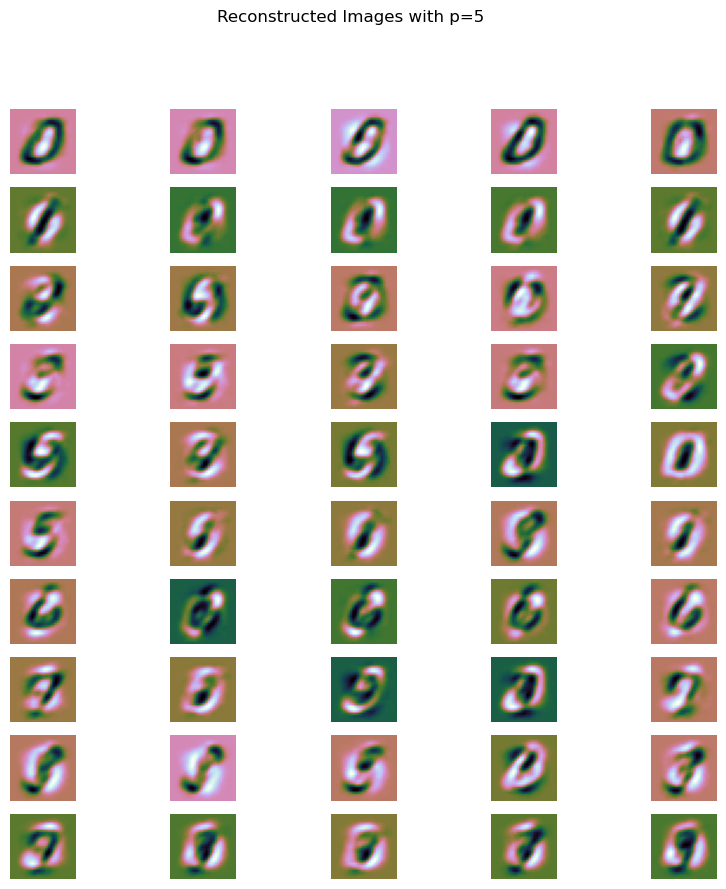

MSE between X and X_recon with p=10: 2122.7215566903


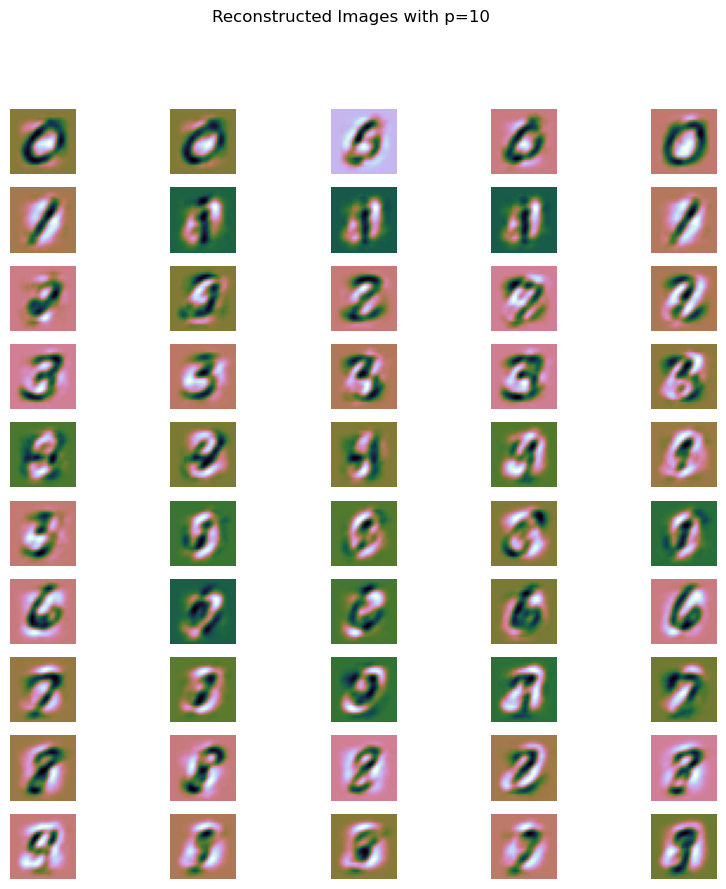

MSE between X and X_recon with p=20: 1454.9593987888684


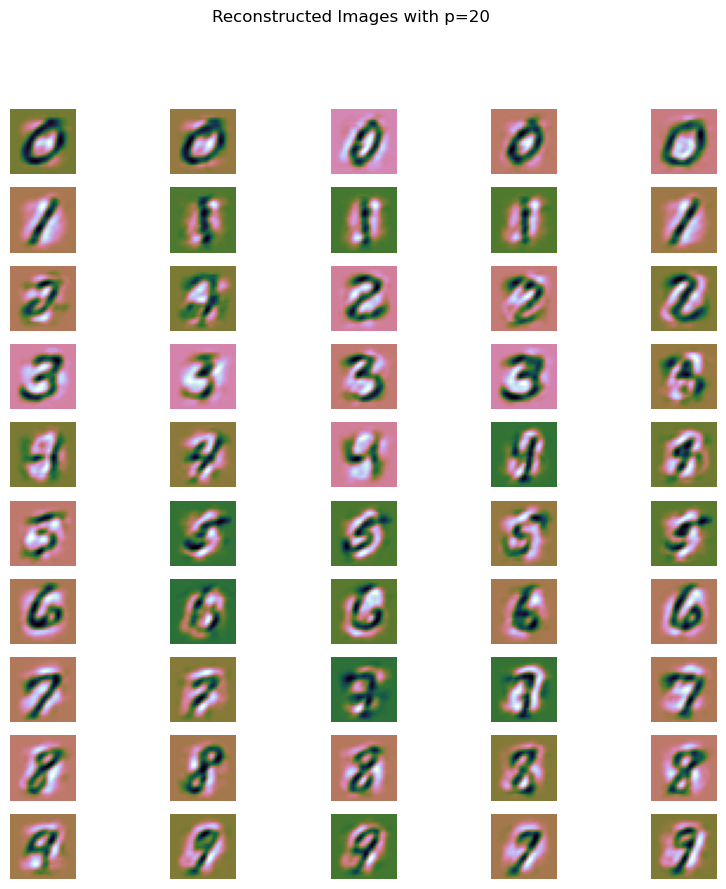

MSE between X and X_recon with p=300: 31.530235821587272


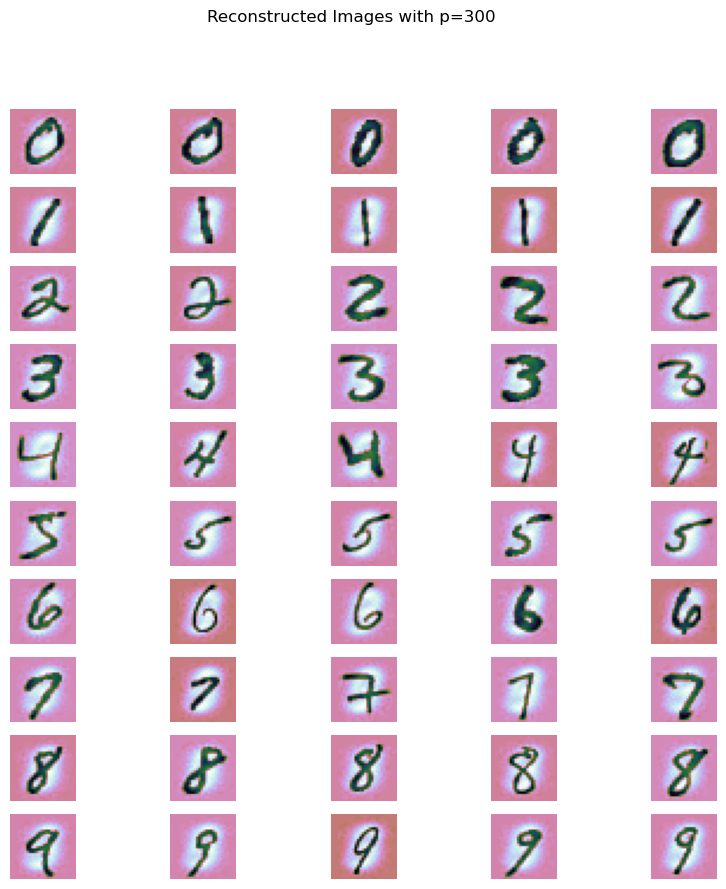

MSE between X and X_recon with p=784: 4.3125109801084515e-26


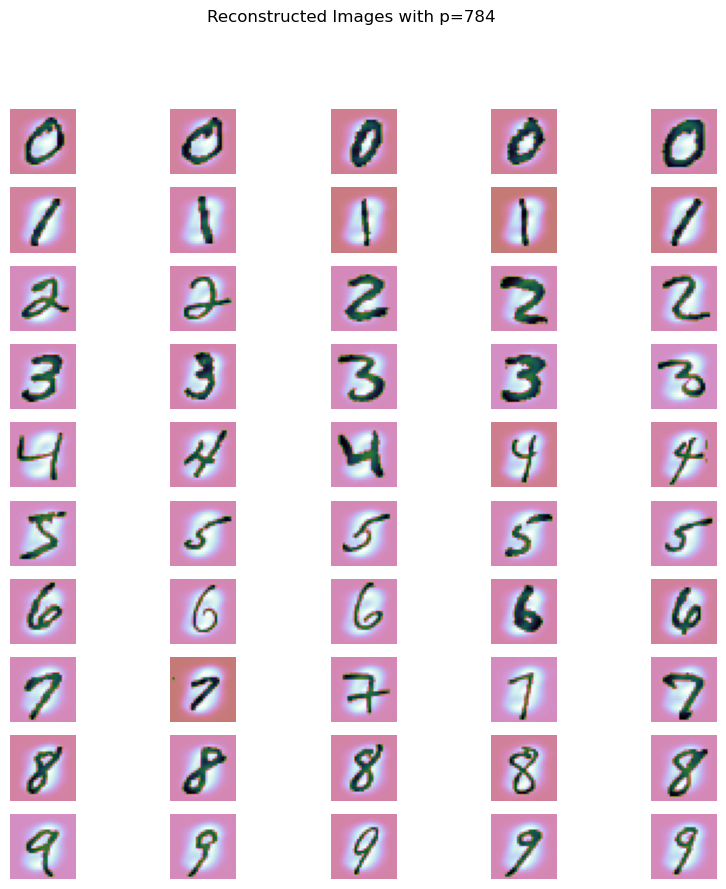

In [20]:

def select_samples_per_class(X_train, y_train, samples_per_class=100):
    selected_samples = []
    y_trains = []

    for i in range(10):
        class_indices = np.where(y_train == i)[0][:samples_per_class]
        selected_samples.extend(class_indices)
        y_trains.extend([i] * samples_per_class)

    y_trains = np.array(y_trains)
    return selected_samples, y_trains

def create_data_matrix(selected_samples, X_train):
    X = X_train[selected_samples].reshape(-1, 784)
    X = X.T
    return X

def center_data(X):
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    return X_centered

def apply_pca(X_centered, p):
    covariance_matrix = np.matmul(X_centered, X_centered.T) / (X_centered.shape[1] - 1)
    V, U = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(V)[::-1]
    U_sorted = U[:, sorted_indices][:, :p]

    Y = U_sorted.T @ X_centered
    return U_sorted, Y

def reconstruct_data(U_sorted, Y):
    X_recon = U_sorted @ Y
    return X_recon

def calculate_mse(X_centered, X_recon):
    mse = np.sum((X_centered - X_recon) ** 2) / X_centered.size
    return mse

def plot_reconstructed_images(X_recon_p, p):
    fig, axes = plt.subplots(10, 5, figsize=(10, 10))
    for i in range(10):
        for j in range(5):
            axes[i, j].imshow(X_recon_p[:, i * 100 + j].reshape(28, 28), cmap='cubehelix_r')
            axes[i, j].axis('off')

    plt.suptitle(f"Reconstructed Images with p={p}")
    plt.show()

def calculate_class_accuracy(y_true, y_pred):
    
    num_classes = 10
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    for true_label, pred_label in zip(y_true, y_pred):
        total_per_class[true_label] += 1
        if true_label == pred_label:
            accuracy_per_class[true_label] += 1

    accuracy_per_class = accuracy_per_class / total_per_class
    return accuracy_per_class
    
    
def main():
    # Assume X_train and y_train are available
    # ...

    samples_per_class = 100
    selected_samples, y_trains = select_samples_per_class(X_train, y_train, samples_per_class)

    X = create_data_matrix(selected_samples, X_train)

    X_centered = center_data(X)

    p_values = [5, 10, 20, 300, 784]
    for p in p_values:
        U_sorted, Y = apply_pca(X_centered, p)

        X_recon = reconstruct_data(U_sorted, Y)

        mse = calculate_mse(X_centered, X_recon)
        print(f"MSE between X and X_recon with p={p}: {mse}")

        plot_reconstructed_images(X_recon, p)


if __name__ == "__main__":
    main()


In [21]:
samples_per_class = 100
selected_samples, y_trains = select_samples_per_class(X_train, y_train, samples_per_class)

X = create_data_matrix(selected_samples, X_train)

X_centered = center_data(X)

p_values = [5, 10, 20, 300, 784]
for p in p_values:
    U_sorted, Y = apply_pca(X_centered, p)
    prior_probabilities, mean_vectors, covariance_matrices = compute_qda_params(Y, y_trains)
    X_test_centered = X_test.reshape(10000, -1).T - np.mean(X, axis=1,keepdims=True)
    Y_test = U_sorted.T @ X_test_centered
    qda_results = compute_qda(Y_test.T, prior_probabilities, mean_vectors, covariance_matrices)
    print("QDA GPU Accuracy : for feature ",p," ", qda_results["accuracy"])
    class_accuracy = calculate_class_accuracy(y_test, qda_results["predicted_classes"])
    print("classwise accuracy -- ")
    for i,j in enumerate(class_accuracy):
        print(f"accuracy of class {i} is {j} " )




Performing QDA on GPU: 100%|██████████| 10/10 [00:00<00:00, 2211.72it/s]


QDA GPU Accuracy : for feature  5   0.7057
classwise accuracy -- 
accuracy of class 0 is 0.8795918367346939 
accuracy of class 1 is 0.9568281938325991 
accuracy of class 2 is 0.7655038759689923 
accuracy of class 3 is 0.7158415841584158 
accuracy of class 4 is 0.6089613034623218 
accuracy of class 5 is 0.5526905829596412 
accuracy of class 6 is 0.7901878914405011 
accuracy of class 7 is 0.7441634241245136 
accuracy of class 8 is 0.42915811088295686 
accuracy of class 9 is 0.5599603567888999 


Performing QDA on GPU: 100%|██████████| 10/10 [00:00<00:00, 1998.52it/s]


QDA GPU Accuracy : for feature  10   0.858
classwise accuracy -- 
accuracy of class 0 is 0.9561224489795919 
accuracy of class 1 is 0.9533039647577093 
accuracy of class 2 is 0.8875968992248062 
accuracy of class 3 is 0.8386138613861386 
accuracy of class 4 is 0.7627291242362525 
accuracy of class 5 is 0.8307174887892377 
accuracy of class 6 is 0.8893528183716075 
accuracy of class 7 is 0.853112840466926 
accuracy of class 8 is 0.7823408624229979 
accuracy of class 9 is 0.8097125867195243 


Performing QDA on GPU: 100%|██████████| 10/10 [00:00<00:00, 526.23it/s]


QDA GPU Accuracy : for feature  20   0.9084
classwise accuracy -- 
accuracy of class 0 is 0.9724489795918367 
accuracy of class 1 is 0.9259911894273127 
accuracy of class 2 is 0.9486434108527132 
accuracy of class 3 is 0.8960396039603961 
accuracy of class 4 is 0.9124236252545825 
accuracy of class 5 is 0.9091928251121076 
accuracy of class 6 is 0.9342379958246346 
accuracy of class 7 is 0.8443579766536965 
accuracy of class 8 is 0.8439425051334702 
accuracy of class 9 is 0.8959365708622399 


Performing QDA on GPU: 100%|██████████| 10/10 [00:00<00:00, 20.75it/s]


QDA GPU Accuracy : for feature  300   0.9218
classwise accuracy -- 
accuracy of class 0 is 0.9816326530612245 
accuracy of class 1 is 0.9797356828193833 
accuracy of class 2 is 0.9428294573643411 
accuracy of class 3 is 0.8465346534653465 
accuracy of class 4 is 0.9185336048879837 
accuracy of class 5 is 0.8699551569506726 
accuracy of class 6 is 0.954070981210856 
accuracy of class 7 is 0.9114785992217899 
accuracy of class 8 is 0.8788501026694046 
accuracy of class 9 is 0.9226957383548068 


Performing QDA on GPU: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]

QDA GPU Accuracy : for feature  784   0.9246
classwise accuracy -- 
accuracy of class 0 is 0.9836734693877551 
accuracy of class 1 is 0.9797356828193833 
accuracy of class 2 is 0.9408914728682171 
accuracy of class 3 is 0.8544554455445544 
accuracy of class 4 is 0.9205702647657841 
accuracy of class 5 is 0.8834080717488789 
accuracy of class 6 is 0.9498956158663883 
accuracy of class 7 is 0.9046692607003891 
accuracy of class 8 is 0.8880903490759754 
accuracy of class 9 is 0.9306243805748265 


In [19]:

# Example usage:


accuracy of class 0 is 0.9836734693877551 
accuracy of class 1 is 0.9797356828193833 
accuracy of class 2 is 0.9408914728682171 
accuracy of class 3 is 0.8544554455445544 
accuracy of class 4 is 0.9205702647657841 
accuracy of class 5 is 0.8834080717488789 
accuracy of class 6 is 0.9498956158663883 
accuracy of class 7 is 0.9046692607003891 
accuracy of class 8 is 0.8880903490759754 
accuracy of class 9 is 0.9306243805748265 


NameError: name 'y_trues' is not defined